## Section 0: Justin Chan

## Section 1: Travel Insurance - Claim Prediction (No SMOTE version)

## Section 2: Project Definition

### Goals

The goal of this project is to determine if we can predict the claim status (Yes or No) from the various travel insurance-related attributes.

### Dataset
- The "Travel Insurance" data is provided by a third-party travel insurance servicing company based in Singapore.
- The data is downloadable from Kaggle, [https://www.kaggle.com/mhdzahier/travel-insurance](https://www.kaggle.com/mhdzahier/travel-insurance)
- The dataset has 63326 records. There are 11 fields/attributes where "Claim" is the target variable.
- The fields and their data types are:

| Field Name   | Data Type |
|----------------:|:-----------------:|
| Agency    |  String |
| Agency Type |  String |
| Distribution Channel |  String |
| Product Name |  String |
| Claim|  Float |
| Duration|  Integer |
| Destination |  String |
| Net Sales|  Float |
| Commision (in value)|  Float |
| Gender |  String |
| Age |  Integer |

### Tasks

1. Do preliminary data exploration and data cleaning
2. Process the dataset to convert strings into labels, address null fields etc.
3. Shuffle and split into train and test sets. Address imbalance in the data, if required.
3. Train a multi-layer perceptron neural network using keras to do prediction.
4. Compute the metrics for the algorithm.
5. Perform analysis for possible improvements.

## Section 3: Data Engineering

We perform several steps in data engineerin
* Data Exploration
    * We want to understand if there is imbalanced data (ie. Claims), nulls, and also the unreasonable values.
* Data Cleaning
    * We want to remove certain outlier data points, and address null fields
* Data Encoding
    * We want to perform one-hot encoding for attributes that are 'categorical'

In [158]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

import pickle

%matplotlib inline

In [159]:
#import data
df_travel=pd.read_csv("travel insurance.csv")
df_travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
Agency                  63326 non-null object
Agency Type             63326 non-null object
Distribution Channel    63326 non-null object
Product Name            63326 non-null object
Claim                   63326 non-null object
Duration                63326 non-null int64
Destination             63326 non-null object
Net Sales               63326 non-null float64
Commision (in value)    63326 non-null float64
Gender                  18219 non-null object
Age                     63326 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


In [160]:
df_travel.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


### Check the target variable, Claim

There are 927 "Yes" vs 62399 "No" records. 

"Yes" makes up 1.46% of all the record - we have a highly imbalanced dataset.

In [161]:
results = df_travel["Claim"].value_counts(dropna=False)
results

No     62399
Yes      927
Name: Claim, dtype: int64

In [162]:
print("Proportion of claims that are Yes: " , results[1]/(results[0] + results[1]))

Proportion of claims that are Yes:  0.014638537093768752


### Check other attributes

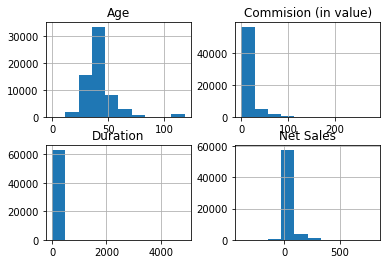

In [163]:
hist=df_travel.hist()

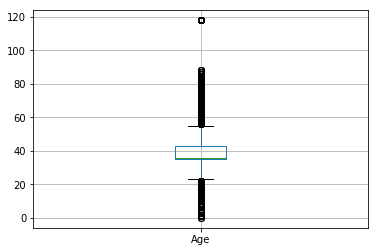

In [164]:
boxplot1 = df_travel.boxplot(column=['Age'])

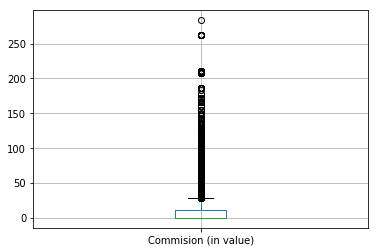

In [165]:
boxplot2 = df_travel.boxplot(column=['Commision (in value)'])

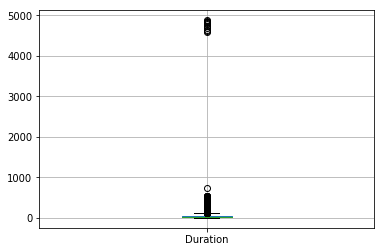

In [166]:
boxplot3 = df_travel.boxplot(column=['Duration'])

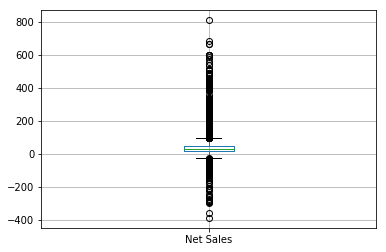

In [167]:
boxplot4 = df_travel.boxplot(column=['Net Sales'])

In [168]:
df_travel.describe()

,Duration,Net Sales,Commision (in value),Age
count,63326.000000,63326.000000,63326.000000,63326.000000
mean,49.317074,40.702018,9.809992,39.969981
std,101.791566,48.845637,19.804388,14.017010
min,-2.000000,-389.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.530000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


We note a few abnormal values in our data:
- For "Age" attribute, we have very high values of up to 118.
- For "Duration" attribute, we have very high values of up to 4881, and also negative values. We assume that duration is measured in days.
- For "Commission (in value)", the highest value of 283.5 seems unreasonable. 
- For "Net Sales", we observe a large range of values for this field with minimum -389. There is possibility of negative values due to cross-subsidies.

In [169]:
df_travel["Agency"].value_counts(dropna=False)

EPX    35119
CWT     8580
C2B     8267
JZI     6329
SSI     1056
JWT      749
RAB      725
LWC      689
TST      528
KML      392
ART      331
CCR      194
CBH      101
TTW       98
CSR       86
ADM       82
Name: Agency, dtype: int64

In [170]:
df_travel["Agency Type"].value_counts(dropna=False)

Travel Agency    45869
Airlines         17457
Name: Agency Type, dtype: int64

In [171]:
df_travel["Distribution Channel"].value_counts(dropna=False)

Online     62219
Offline     1107
Name: Distribution Channel, dtype: int64

In [172]:
df_travel["Product Name"].value_counts(dropna=False)

Cancellation Plan                       18630
2 way Comprehensive Plan                13158
Rental Vehicle Excess Insurance          8580
Basic Plan                               5469
Bronze Plan                              4049
1 way Comprehensive Plan                 3331
Value Plan                               2715
Silver Plan                              2249
Annual Silver Plan                       1423
Ticket Protector                         1056
Travel Cruise Protect                     527
Comprehensive Plan                        364
Gold Plan                                 352
24 Protect                                247
Single Trip Travel Protect Gold           204
Annual Gold Plan                          194
Premier Plan                              194
Single Trip Travel Protect Silver         173
Annual Travel Protect Gold                100
Annual Travel Protect Silver               86
Individual Comprehensive Plan              74
Single Trip Travel Protect Platinu

In [173]:
df_travel["Destination"].value_counts(dropna=False)

SINGAPORE                                 13255
MALAYSIA                                   5930
THAILAND                                   5894
CHINA                                      4796
AUSTRALIA                                  3694
INDONESIA                                  3452
UNITED STATES                              2530
PHILIPPINES                                2490
HONG KONG                                  2411
INDIA                                      2251
JAPAN                                      2061
VIET NAM                                   1669
KOREA, REPUBLIC OF                         1479
UNITED KINGDOM                             1309
TAIWAN, PROVINCE OF CHINA                  1090
MYANMAR                                     806
BRUNEI DARUSSALAM                           780
NEW ZEALAND                                 537
CANADA                                      528
CAMBODIA                                    493
FRANCE                                  

In [174]:
df_travel["Gender"].value_counts(dropna=False)

NaN    45107
M       9347
F       8872
Name: Gender, dtype: int64

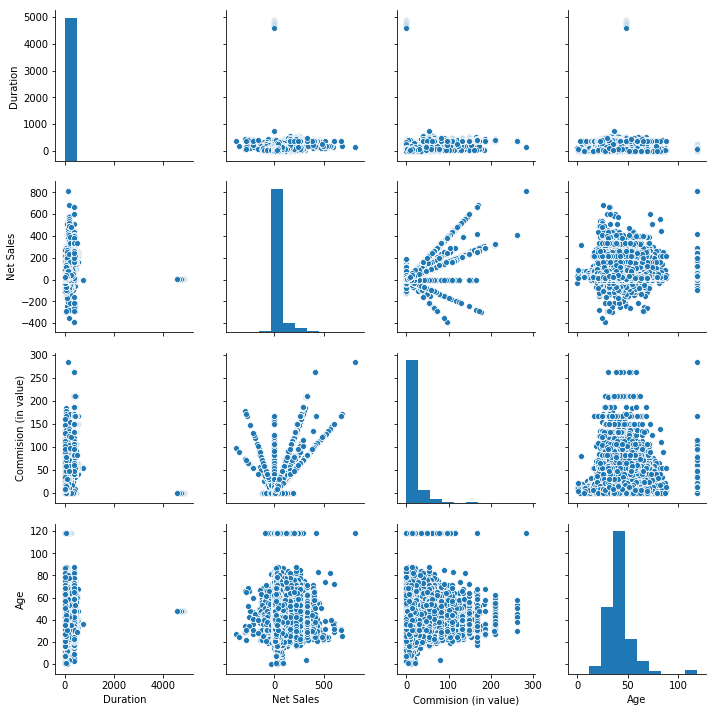

In [175]:
sns.pairplot(df_travel)

We note that there is are particular linear relationships between "Net Sales" and "Commission (in value).
This is an area of investigation to see if it related to Agency or other attributes.

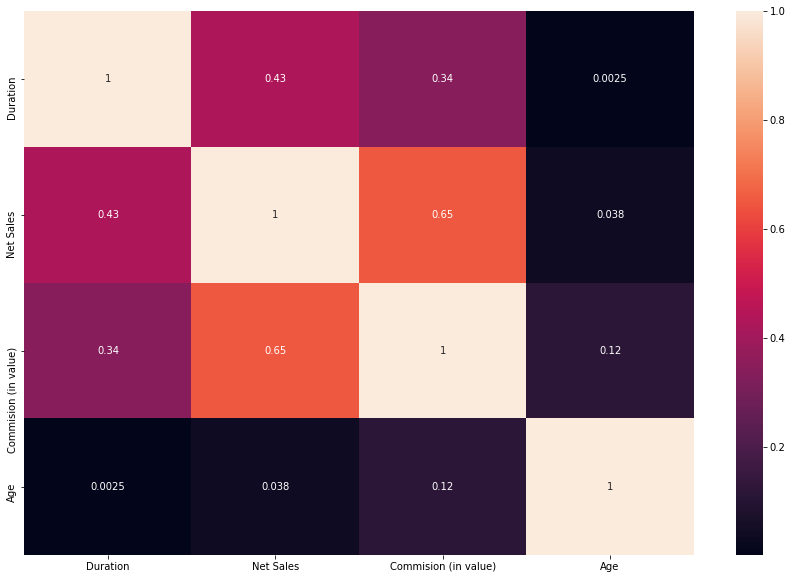

In [176]:
#Correlation Plot
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_travel.corr(), annot=True, ax=ax)

### Data Cleaning
We remove records where:
- Age > 100
- Commission (in value) > 250
- Duration > 1000

In [177]:
df_travel1 = df_travel[ df_travel["Age"]<=100]
df_travel2 = df_travel1[ df_travel1["Commision (in value)"]<=250]
df_travel3 = df_travel2[ df_travel2["Duration"]<=1000]

### One-hot encoding other string attributes

In [178]:
# setup the encoder
le = LabelEncoder()
df_travel4=df_travel3.copy()

# do the encoding for Agency
le.fit(df_travel4['Agency'])
df_travel4['Agency encoded'] = le.transform(df_travel4['Agency'])
df_travel5 = pd.concat([df_travel4, pd.get_dummies(df_travel4['Agency'])], axis=1)

# do the encoding for Agency Type
le.fit(df_travel5['Agency Type'])
df_travel5['Agency Type encoded'] = le.transform(df_travel5['Agency Type'])
df_travel6 = pd.concat([df_travel5, pd.get_dummies(df_travel5['Agency Type'])], axis=1)

# do the encoding for Distribution Channel
le.fit(df_travel6['Distribution Channel'])
df_travel6['Distribution Channel encoded'] = le.transform(df_travel6['Distribution Channel'])
df_travel7 = pd.concat([df_travel6, pd.get_dummies(df_travel6['Distribution Channel'])], axis=1)

# do the encoding for Product Name
le.fit(df_travel7['Product Name'])
df_travel7['Product Name encoded'] = le.transform(df_travel7['Product Name'])
df_travel8 = pd.concat([df_travel7, pd.get_dummies(df_travel7['Product Name'])], axis=1)

# do the encoding for Destination
le.fit(df_travel8['Destination'])
df_travel8['Destination encoded'] = le.transform(df_travel8['Destination'])
df_travel9 = pd.concat([df_travel8, pd.get_dummies(df_travel8['Destination'])], axis=1)

# do the encoding for Gender
#first, address NaN
df_travel9['Gender'].fillna("Other", inplace=True)
le.fit(df_travel9['Gender'])
df_travel9['Gender encoded'] = le.transform(df_travel9['Gender'])
df_travel10 = pd.concat([df_travel9, pd.get_dummies(df_travel9['Gender'])], axis=1)

# encode the Claim variable. 1 for "Yes", 0 for "No"
df_travel10["Claim_Target"] = np.where(df_travel10["Claim"]=='Yes', 1, 0)
df_travel10.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,...,VENEZUELA,VIET NAM,"VIRGIN ISLANDS, U.S.",ZAMBIA,ZIMBABWE,Gender encoded,F,M,Other,Claim_Target
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,...,0,0,0,0,0,0,1,0,0,0
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,...,0,0,0,0,0,0,1,0,0,0
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,Other,...,0,0,0,0,0,2,0,0,1,0
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,Other,...,0,0,0,0,0,2,0,0,1,0
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,Other,...,0,0,0,0,0,2,0,0,1,0


In [179]:
#check imbalance dataset
df_travel10["Claim_Target"].value_counts(dropna=False)

0    61403
1      917
Name: Claim_Target, dtype: int64

## Section 4: Feature Engineering

We undertake the following tasks:
* Select features and split into training and test sets
* Treat imbalance of data using SMOTE
    * Perform PCA plot in 2D before and after SMOTE
* Apply StandardScaler to data after SMOTE (to be used in subsequent PCA plot, and in model)

### Select features

In [180]:
df_col=pd.DataFrame(df_travel10.columns)
df_col.columns=["Column_Name"]

In [181]:
# output to csv because we can't get it to print all of it
df_col.to_csv("travel_ins_col_names.csv")

In [182]:
#split dataset between features and target
features=['Duration', 'Net Sales', 'Commision (in value)', 'Age', 'ADM', 'ART', 'C2B', 'CBH', 'CCR', 'CSR', 'CWT', 'EPX', 'JZI', 'KML', 'LWC', 'RAB', 'SSI', 'TST', 'TTW', 'Airlines', 'Travel Agency', 'Offline', 'Online', '1 way Comprehensive Plan', '2 way Comprehensive Plan', '24 Protect', 'Annual Gold Plan', 'Annual Silver Plan', 'Annual Travel Protect Gold', 'Annual Travel Protect Platinum', 'Annual Travel Protect Silver', 'Basic Plan', 'Bronze Plan', 'Cancellation Plan', 'Child Comprehensive Plan', 'Comprehensive Plan', 'Gold Plan', 'Individual Comprehensive Plan', 'Premier Plan', 'Rental Vehicle Excess Insurance', 'Silver Plan', 'Single Trip Travel Protect Gold', 'Single Trip Travel Protect Platinum', 'Single Trip Travel Protect Silver', 'Spouse or Parents Comprehensive Plan', 'Ticket Protector', 'Travel Cruise Protect', 'Travel Cruise Protect Family', 'Value Plan', 'ALBANIA', 'ANGOLA', 'ARGENTINA', 'ARMENIA', 'AUSTRALIA', 'AUSTRIA', 'AZERBAIJAN', 'BAHRAIN', 'BANGLADESH', 'BARBADOS', 'BELARUS', 'BELGIUM', 'BENIN', 'BERMUDA', 'BHUTAN', 'BOLIVIA', 'BOSNIA AND HERZEGOVINA', 'BOTSWANA', 'BRAZIL', 'BRUNEI DARUSSALAM', 'BULGARIA', 'CAMBODIA', 'CAMEROON', 'CANADA', 'CAYMAN ISLANDS', 'CHILE', 'CHINA', 'COLOMBIA', 'COSTA RICA', 'CROATIA', 'CYPRUS', 'CZECH REPUBLIC', 'DENMARK', 'DOMINICAN REPUBLIC', 'ECUADOR', 'EGYPT', 'ESTONIA', 'ETHIOPIA', 'FAROE ISLANDS', 'FIJI', 'FINLAND', 'FRANCE', 'FRENCH POLYNESIA', 'GEORGIA', 'GERMANY', 'GHANA', 'GREECE', 'GUADELOUPE', 'GUAM', 'GUATEMALA', 'GUINEA', 'GUINEA-BISSAU', 'GUYANA', 'HONG KONG', 'HUNGARY', 'ICELAND', 'INDIA', 'INDONESIA', 'IRAN, ISLAMIC REPUBLIC OF', 'IRELAND', 'ISRAEL', 'ITALY', 'JAMAICA', 'JAPAN', 'JORDAN', 'KAZAKHSTAN', 'KENYA', 'KOREA, REPUBLIC OF', 'KUWAIT', 'KYRGYZSTAN', "LAO PEOPLE'S DEMOCRATIC REPUBLIC", 'LATVIA', 'LEBANON', 'LIBYAN ARAB JAMAHIRIYA', 'LITHUANIA', 'LUXEMBOURG', 'MACAO', 'MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF', 'MALAYSIA', 'MALDIVES', 'MALI', 'MALTA', 'MAURITIUS', 'MEXICO', 'MOLDOVA, REPUBLIC OF', 'MONGOLIA', 'MOROCCO', 'MYANMAR', 'NAMIBIA', 'NEPAL', 'NETHERLANDS', 'NEW CALEDONIA', 'NEW ZEALAND', 'NIGERIA', 'NORTHERN MARIANA ISLANDS', 'NORWAY', 'OMAN', 'PAKISTAN', 'PANAMA', 'PAPUA NEW GUINEA', 'PERU', 'PHILIPPINES', 'POLAND', 'PORTUGAL', 'PUERTO RICO', 'QATAR', 'REPUBLIC OF MONTENEGRO', 'REUNION', 'ROMANIA', 'RUSSIAN FEDERATION', 'RWANDA', 'SAMOA', 'SAUDI ARABIA', 'SENEGAL', 'SERBIA', 'SEYCHELLES', 'SIERRA LEONE', 'SINGAPORE', 'SLOVENIA', 'SOLOMON ISLANDS', 'SOUTH AFRICA', 'SPAIN', 'SRI LANKA', 'SWEDEN', 'SWITZERLAND', 'TAIWAN, PROVINCE OF CHINA', 'TAJIKISTAN', 'TANZANIA, UNITED REPUBLIC OF', 'THAILAND', 'TRINIDAD AND TOBAGO', 'TUNISIA', 'TURKEY', 'TURKMENISTAN', 'TURKS AND CAICOS ISLANDS', 'UGANDA', 'UKRAINE', 'UNITED ARAB EMIRATES', 'UNITED KINGDOM', 'UNITED STATES', 'URUGUAY', 'UZBEKISTAN', 'VANUATU', 'VENEZUELA', 'VIET NAM', 'VIRGIN ISLANDS, U.S.', 'ZAMBIA', 'ZIMBABWE', 'F', 'M', 'Other']
target = "Claim_Target"

X = df_travel10.loc[:, features]
y = df_travel10[target]
X.head()

,Duration,Net Sales,Commision (in value),Age,ADM,ART,C2B,CBH,CCR,CSR,...,UZBEKISTAN,VANUATU,VENEZUELA,VIET NAM,"VIRGIN ISLANDS, U.S.",ZAMBIA,ZIMBABWE,F,M,Other
0,186,-29.0,9.57,81,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,186,-29.0,9.57,71,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,65,-49.5,29.70,32,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60,-39.6,23.76,32,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,79,-19.8,11.88,41,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [183]:
#split between training and test set, default 4:1
X_train1, X_test1, y_train, y_test = train_test_split(X, y)
X_train1.shape, X_test1.shape, y_train.shape, y_test.shape

((46740, 199), (15580, 199), (46740,), (15580,))

### Do scaling and use Smote to deal with data imbalance

In [184]:
# Do scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train1)
X_test=scaler.transform(X_test1)

C:\Users\Justin\Anaconda3\envs\mldds\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Justin\Anaconda3\envs\mldds\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Justin\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


(46740, 2)
(46740,)
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


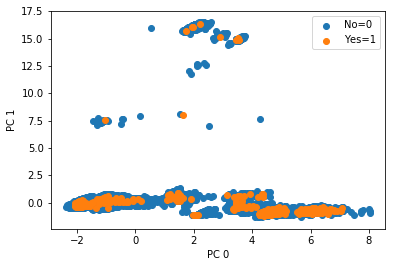

In [185]:
# Do PCA before and after SMOTE to see effects
pca_2d_before = PCA(n_components=2)
pca_2d_before.fit(X_train)
Z_train_pca_2d_before = pca_2d_before.transform(X_train)

print(Z_train_pca_2d_before.shape)
print(y_train.shape)
print(type(Z_train_pca_2d_before), type(y_train))

mask0 = (y_train == 0)
mask1 = (y_train == 1)

fig, ax = plt.subplots()

# ax.scatter(Z[:, 0], Z[:, 1]) # Z[:, 0] - first col, Z[:, 1], 2nd col

# numpy slicing arr[row, col]
ax.scatter(Z_train_pca_2d_before[mask0, 0], Z_train_pca_2d_before[mask0, 1], label='No=0')
ax.scatter(Z_train_pca_2d_before[mask1, 0], Z_train_pca_2d_before[mask1, 1], label='Yes=1')

ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.legend()
plt.show()

In [186]:
y_train.sum()

699

In [187]:
num_input_features = len(features)
num_input_features

199

## Section 5: Model Engineering

We will use a multi-layer perceptron neural network for prediction/classification.

The model will have 3 layers - one with 199 nodes, 2nd with 50 nodes and output layer with 2 nodes.

In [188]:
#code to clear old keras model
import keras
keras.backend.clear_session()

In [189]:
from keras.models import Sequential
from keras.layers import Dense
# from keras.layers import Dropout

model = Sequential()

#input num_input_features, 199. 
#output 199 as well. 
model.add(Dense(199, activation='relu', input_shape=(num_input_features,)))
# model.add(Dropout(0.2))

#input 199. output 50
model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.2))

# softmax converts a set of outputs to probabilities that add up to 1
num_classes=2 #didn't work with 1, so try two
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 199)               39800     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                10000     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 49,902
Trainable params: 49,902
Non-trainable params: 0
_________________________________________________________________


In [190]:
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop
from keras.utils import to_categorical
import time

batch_size = 10
epochs = 20

y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)

tensorboard = TensorBoard(log_dir='./logs/insurance_mlp/%d' % time.time())
earlystop = EarlyStopping(monitor='val_loss', patience=1, mode='auto')
checkpoint = ModelCheckpoint('travel_insurance_model.h5')

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy']) # Tensorboard will display
                                    # acc in addition to loss

history = model.fit(X_train, y_train_binary,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[tensorboard, earlystop, checkpoint],
                    validation_data=(X_test, y_test_binary))

Train on 46740 samples, validate on 15580 samples
Epoch 1/20
46740/46740 [==============================] - 11s 234us/step - loss: 0.0806 - acc: 0.9850 - val_loss: 0.0793 - val_acc: 0.9860
Epoch 2/20
46740/46740 [==============================] - 11s 231us/step - loss: 0.0856 - acc: 0.9845 - val_loss: 0.0721 - val_acc: 0.9860
Epoch 3/20
46740/46740 [==============================] - 12s 257us/step - loss: 0.0893 - acc: 0.9834 - val_loss: 0.1100 - val_acc: 0.9860


## Section 6: Evaluate Metrics

We use look at the confusion matrix, precision, recall and F1 scores to see assess the performance of the model.

In [191]:
#do prediction for test data
y_pred = model.predict_classes(X_test)

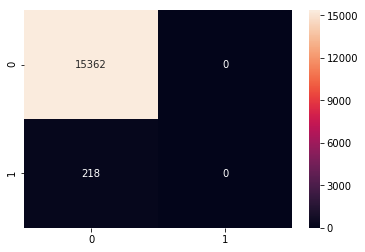

In [192]:
# Computing metrics
from sklearn.metrics import confusion_matrix, classification_report
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

In [193]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15362
           1       0.00      0.00      0.00       218

   micro avg       0.99      0.99      0.99     15580
   macro avg       0.49      0.50      0.50     15580
weighted avg       0.97      0.99      0.98     15580



C:\Users\Justin\Anaconda3\envs\mldds\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Justin\Anaconda3\envs\mldds\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Justin\Anaconda3\envs\mldds\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Section 7: Observations and analysis

Answer the following questions:
1. What do you conclude from the metrics?

2. If the metrics are not good, try to find out what is the reason in order to improve the model. What kind of inputs does the model not do well? (i.e. what are the blind spots or invalid assumptions?). Note that to answer this question, you need to decide what a "good" result is for your problem formulation.

3. What improvements do you propose?

Here are some observations.
* This notebook provides a baseline for claims classification.
* The model suffers from 'illusion of accuracy'. 
    * Due to the large number of 'No' claims (98.54%), the model predicts all claims as 'No'.
    * The resulting training and validation accuracies are 0.9834 and 0.9860 respectively.
    * Precision, recall and F1 score for 'Yes' claims are all 0. 
* We can improve on this model by address the issue of imbalanced dataset using techniques like under/over-sampling or SMOTE.